# Applying ML models on the dataset

In [29]:
#import libraries
import warnings

def function_that_warns():
    warnings.warn("This is a warning message", UserWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    function_that_warns()  # This will not show a warning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lime
import lime.lime_tabular
import shap
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Functions

In [2]:
def draw_histograms(arr, variables, n_rows, n_cols):
    df = pd.DataFrame(arr, columns =variables)
    fig=plt.figure(figsize=(20, 20))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

In [3]:
# normalsie the input base on the norm parametrs, if norm is none, no normalisation will happen
def normalisation(X_train,X_test, norm ):
    if norm != None:
        scaler1 = norm
        X_train  =  scaler1.fit_transform(X_train)
        X_test  =  scaler1.transform(X_test)
    return X_train, X_test

In [4]:
def remove_outliers_zscore(X,y, threshold=3):
    z_scores = np.abs(stats.zscore(X))
    mask = (z_scores < threshold).all(axis=1)
    X = X[mask]
    y = y[mask]
    print(X.shape)
    return  X,y
def read_csv(path, target , remove_outliers = True, log = True  ):
    df = pd.read_csv(path)
    df['Region'] = pd.factorize( df['Region'] )[0]
    df['Industry'] = pd.factorize( df['Industry'] )[0]
    df['Employee _size'] = pd.factorize( df['Employee _size'] )[0]

    
    y = df[target].to_numpy()
    X = df.drop(target, axis=1).to_numpy()
    if remove_outliers:
        X , y = remove_outliers_zscore (X,y)
    if log:
      
        X[:,5:] = np.log1p(X[:,5:])
    
    X_train, X_test,y_train, y_test = train_test_split(X,y , 
                                   random_state=10,  
                                   test_size=0.2,  
                                   shuffle=True)
    X_train,X_test = normalisation(X_train,X_test, StandardScaler())
       
    return X_train, X_test,y_train, y_test, X,y




In [5]:
# calculate different performance metric for the model clf
def clf_score(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    ma = mean_absolute_error(y_test,y_pred)
    ms = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)   
    return [ma,ms,r2]

In [6]:
# calculate mean and std for kfold results
def show_statics(arr,type):  
   
    ma = np.mean([ x[0] for x in arr]), np.std([ x[0] for x in arr])
    ms = np.mean([ x[1] for x in arr]), np.std([ x[1] for x in arr])
    r2 = np.mean([ x[2] for x in arr]), np.std([ x[2] for x in arr])
    
    return [ma,ms,r2,type ] 
    
# convert input array into a string 
def make_sring(a):
    return  a[3]+' '+str(round(a[0][0],2))+' +-' + str(round(a[0][1],2))+ ' '+ str(round(a[1][0],0))+' +-' + str(round(a[1][1],0))+ ' '+str(round(a[2][0]*100,2))+' +-' + str(round(a[2][1]*100,2))+ ' '
 

In [7]:
# train a model and 
def train_clf(clf, X_tr,y_tr,X_test, y_test,   print_ind = False, to_string = True):
    metrics_train = []
    metrics_valid = []
    metrics_test = []
    for i, (train_index, valid_index) in enumerate(kf.split(X_tr)):
             
        X_train = X_tr[train_index]
        y_train = y_tr[train_index]
        X_valid = X_tr[valid_index]
        y_valid = y_tr[valid_index]
        
        
       
        
        clf.fit(X_train, y_train.ravel())

        res = clf_score(clf,X_train,y_train)
        if (print_ind): print('Train: ', res)
        metrics_train.append(res)
        
        res = clf_score(clf,X_valid,y_valid)
        if (print_ind): print('Valid: ', res)
        metrics_valid.append(res)
        
        res = clf_score(clf,X_test,y_test)
        if (print_ind): print('Test: ', res)
        metrics_test.append(res)
    #print(show_statics( Accs))
    if to_string :
        return make_sring(show_statics( metrics_train,'train')), make_sring(show_statics( metrics_valid,'valid'))  , make_sring(show_statics( metrics_test,'test'))  
    else:
        return (show_statics( metrics_train,'train')), (show_statics( metrics_valid,'valid'))  , (show_statics( metrics_test,'test'))  


In [8]:
def apply_model(model,X_train,y_train,X_test, y_test, to_string = True ):
       
    ma_t,ms_t,r2_t = train_clf(model,X_train,y_train.reshape(-1, 1),X_test, y_test,False, to_string )
     
    return ma_t,ms_t,r2_t

## Prepration

### Parameters

In [21]:
#reading files 
imputed_file_knn = "Cleaned_data_knn_imputed_df.csv"
imputed_file_em = "Cleaned_data_em_imputed_df.csv"
imputed_file_ct = "Cleaned_data_imputed_df.csv" 
     
df_features =  pd.read_csv(imputed_file_knn).columns
df_target = "Turnover"
kf = KFold(n_splits=10, random_state=0, shuffle = True)
norm =  StandardScaler()

In [10]:
def read_csv(path, target , remove_outliers = True, log = True  ):
    df = pd.read_csv(path)
    df.head()
    df['Region'] = pd.factorize( df['Region'] )[0]
    df['Industry'] = pd.factorize( df['Industry'] )[0]
    df['Employee _size'] = pd.factorize( df['Employee _size'] )[0]

    
    y = df[target].to_numpy()
    X = df.drop(target, axis=1).to_numpy()
    if remove_outliers:
        X , y = remove_outliers_zscore (X,y)
    if log:
      for i in range(5,X.shape[1],1):
        min_value = np.min(X[:,i],0) 
        if (min_value< 0):
            X[:,i] = X[:,i] + abs(min_value) + 0.0000001
        
        X[:,i] = np.log1p(X[:,i])
    
    
    X_train, X_test,y_train, y_test = train_test_split(X,y , 
                                   random_state=10,  
                                   test_size=0.2,  
                                   shuffle=True)
    #X_train,X_test = normalisation(X_train,X_test, StandardScaler())
       
    return X_train, X_test,y_train, y_test, X,y


### Reading files

In [11]:
X_train_knn ,X_test_knn , y_train_knn ,y_test_knn,X_knn,y_knn  = read_csv(imputed_file_knn,df_target, remove_outliers = False, log= False)
X_train_em ,X_test_em , y_train_em ,y_test_em,X_em,y_em = read_csv(imputed_file_em,df_target, remove_outliers = False, log= False)

X_train_ct ,X_test_ct , y_train_ct ,y_test_ct,X_ct,y_ct= read_csv(imputed_file_ct,df_target, remove_outliers = False, log= False)

### Correlation

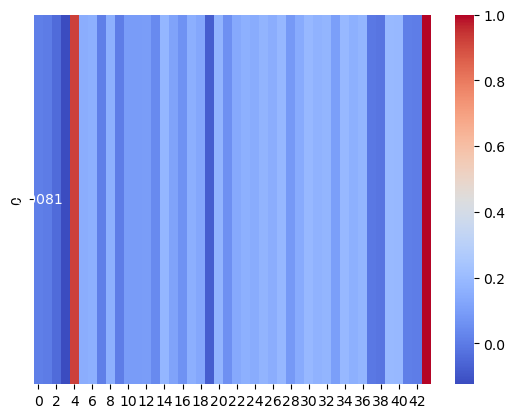

GDP CVM (in 2019 money value) 		 0.18807716900562113
Subsidies 		 0.18923605084484416
Total Exp. (excl. Local Govt.) 		 0.18986893235170285
GDP CVM Index, 2019 equals 100 		 0.19295919780984616
Employment_number 		 0.9209582087413349


In [12]:
#KNN
xx = np.concatenate((X_knn,y_knn.reshape(-1,1)), axis = 1)
corr_matrix = np.corrcoef(xx, rowvar=False)
sns.heatmap(corr_matrix[43:,:], annot=True, cmap='coolwarm')
plt.show()
data = np.abs( corr_matrix[43:,:43].reshape(-1))
indices = np.argpartition(data, -5)[-5:]
top_5_values = data[indices]
for i,j in zip(df_features[indices].tolist(), top_5_values):
    print(i,'\t\t',j)

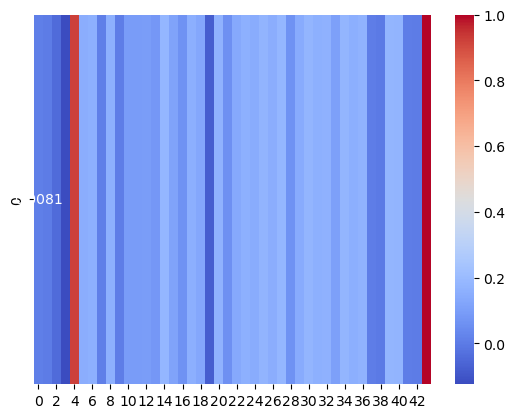

Subsidies 		 0.1773875855688467
Total Exp. (excl. Local Govt.) 		 0.17781341716438862
Defence Exp. 		 0.17896145926609136
Social Protection Exp. 		 0.18170260011236364
Employment_number 		 0.9209676199777183


In [13]:
#EM
xx = np.concatenate((X_em,y_em.reshape(-1,1)), axis = 1)
corr_matrix = np.corrcoef(xx, rowvar=False)
sns.heatmap(corr_matrix[43:,:], annot=True, cmap='coolwarm')
plt.show()
data = np.abs( corr_matrix[43:,:43].reshape(-1))
indices = np.argpartition(data, -5)[-5:]
top_5_values = data[indices]
for i,j in zip(df_features[indices].tolist(), top_5_values):
    print(i,'\t\t',j)

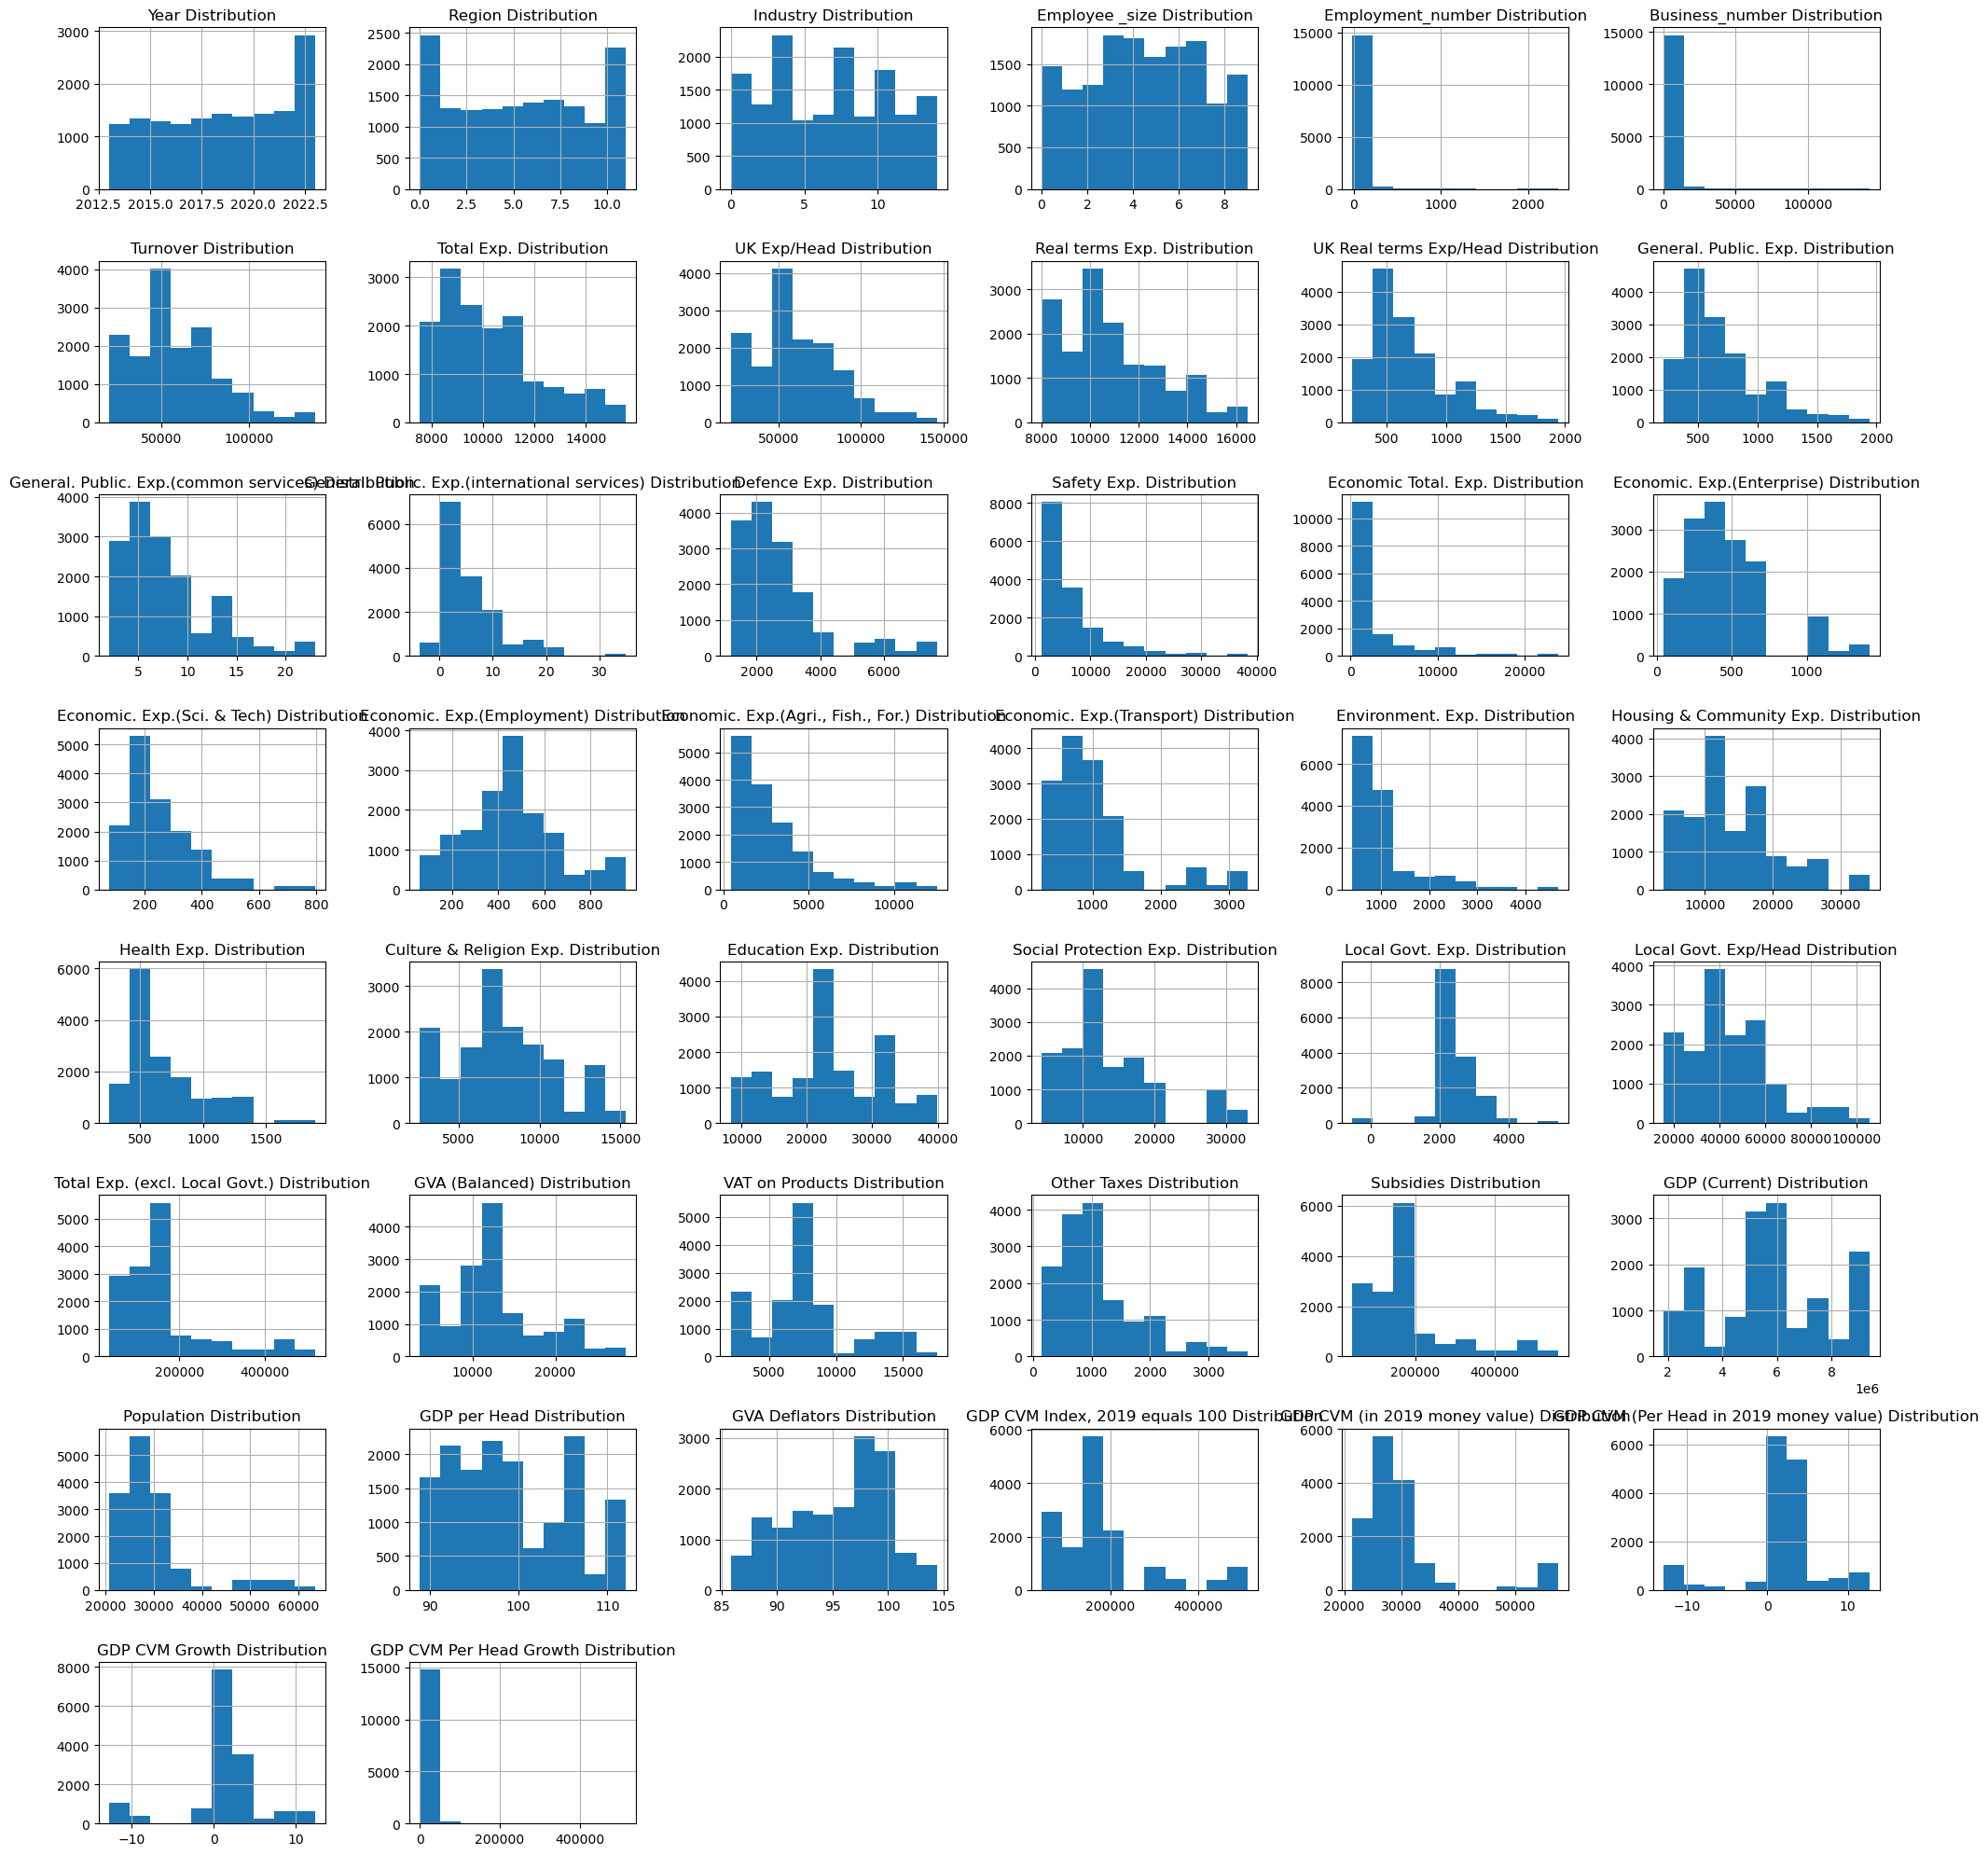

In [14]:
draw_histograms(xx, df_features, 8, 6)

# Aplying Machine learning model 


In [15]:
models = [
          LinearRegression(positive=False),
          Ridge(),
          GradientBoostingRegressor(),
          RandomForestRegressor(), 
          SVR(), 
          MLPRegressor( alpha=1e-5, max_iter=5000,hidden_layer_sizes=(16, 1), random_state=1),
         ]


for model in models:
        print(model)
        print('KNN : ', apply_model(model, X_train_knn, y_train_knn ,X_test_knn  ,y_test_knn))
        print('EM  : ', apply_model(model, X_train_em, y_train_em ,X_test_em  ,y_test_em))
        print('CT  : ',apply_model(model, X_train_ct, y_train_ct ,X_test_ct  ,y_test_ct))

 

LinearRegression()
KNN :  ('train 2890.81 +-49.64 63707439.0 +-1938650.0 84.79 +-0.71 ', 'valid 2911.63 +-222.27 65453751.0 +-17555662.0 81.28 +-8.79 ', 'test 2622.44 +-43.23 38350510.0 +-829790.0 90.13 +-0.21 ')
EM  :  ('train 2813.72 +-44.98 64218193.0 +-1997137.0 84.67 +-0.74 ', 'valid 2829.64 +-213.02 65396653.0 +-17884473.0 81.25 +-8.93 ', 'test 2547.03 +-33.43 38129041.0 +-851879.0 90.19 +-0.22 ')
CT  :  ('train 2813.72 +-44.98 64218193.0 +-1997137.0 84.67 +-0.74 ', 'valid 2829.64 +-213.02 65396653.0 +-17884473.0 81.25 +-8.93 ', 'test 2547.03 +-33.43 38129041.0 +-851879.0 90.19 +-0.22 ')
Ridge()
KNN :  ('train 2890.71 +-49.63 63707440.0 +-1938650.0 84.79 +-0.71 ', 'valid 2911.53 +-222.27 65453379.0 +-17555970.0 81.28 +-8.79 ', 'test 2622.32 +-43.2 38350346.0 +-829759.0 90.13 +-0.21 ')
EM  :  ('train 2813.68 +-44.97 64218193.0 +-1997137.0 84.67 +-0.74 ', 'valid 2829.59 +-213.02 65396476.0 +-17884607.0 81.25 +-8.93 ', 'test 2546.97 +-33.42 38128796.0 +-851840.0 90.19 +-0.22 ')
CT  

In [16]:
model = RandomForestRegressor()
model.fit(X_train_knn, y_train_knn )

explainer = lime.lime_tabular.LimeTabularExplainer(X_train_knn, feature_names=df_features, mode='regression')
i = 0  # Index of the instance to explain
exp = explainer.explain_instance(X_test_knn[i], model.predict, num_features=5)
exp.show_in_notebook(show_table=True)



PermutationExplainer explainer: 3014it [59:50,  1.19s/it]                                                              


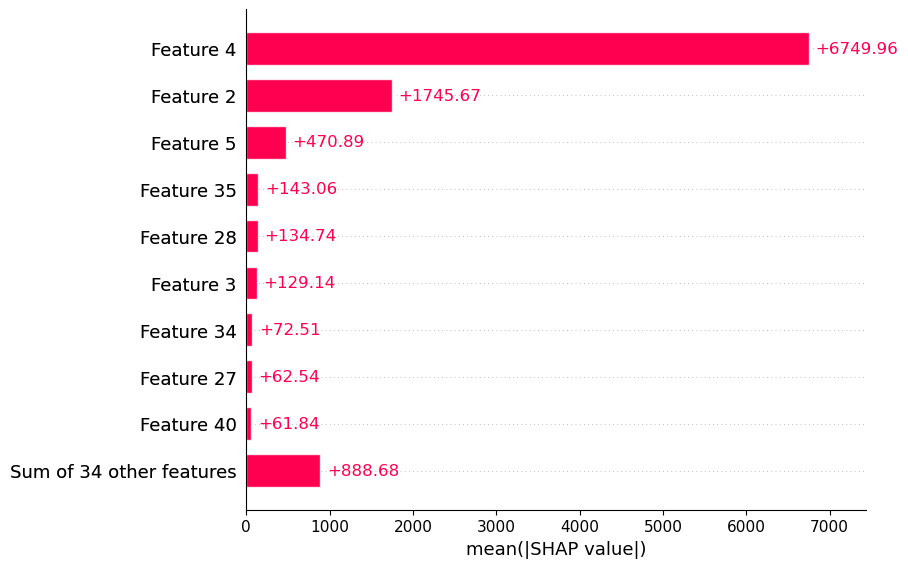

In [17]:
# Initialize SHAP explainer
explainer = shap.Explainer(model, X_train_knn)
# Explain a single instance
i = 0  # Index of the instance to explain
explainer = shap.Explainer(model.predict,X_test_knn)

# Visualize the explanation
shap_values = explainer(X_test_knn)
shap.plots.bar(shap_values)


## Fine tuning


In [18]:
# LinearRegression
fit_intercept = [True, False]
positive = [True, False]
for f in fit_intercept:
    for p in positive:
        model_LR = LinearRegression( fit_intercept = f, positive= p )
        print(model_LR)
        print('KNN : ',apply_model(model_LR, X_train_knn, y_train_knn ,X_test_knn  ,y_test_knn))
        print('EM  : ', apply_model(model_LR, X_train_em, y_train_em ,X_test_em  ,y_test_em)) 


LinearRegression(positive=True)
KNN :  ('train 2831.27 +-36.41 66088418.0 +-2021015.0 84.22 +-0.75 ', 'valid 2837.54 +-215.21 66630061.0 +-18019604.0 80.95 +-8.83 ', 'test 2571.38 +-29.68 39333861.0 +-796513.0 89.88 +-0.21 ')
EM  :  ('train 2829.17 +-37.12 66372729.0 +-2026690.0 84.15 +-0.76 ', 'valid 2836.32 +-219.7 67029983.0 +-18049938.0 80.77 +-8.99 ', 'test 2566.12 +-28.22 39332798.0 +-816060.0 89.88 +-0.21 ')
LinearRegression()
KNN :  ('train 2890.81 +-49.64 63707439.0 +-1938650.0 84.79 +-0.71 ', 'valid 2911.63 +-222.27 65453751.0 +-17555662.0 81.28 +-8.79 ', 'test 2622.44 +-43.23 38350510.0 +-829790.0 90.13 +-0.21 ')
EM  :  ('train 2813.72 +-44.98 64218193.0 +-1997137.0 84.67 +-0.74 ', 'valid 2829.64 +-213.02 65396653.0 +-17884473.0 81.25 +-8.93 ', 'test 2547.03 +-33.43 38129041.0 +-851879.0 90.19 +-0.22 ')
LinearRegression(fit_intercept=False, positive=True)
KNN :  ('train 2695.99 +-33.74 69106112.0 +-2088250.0 83.5 +-0.8 ', 'valid 2700.76 +-226.74 69616961.0 +-18615039.0 79.99

In [19]:
# RIDGE
alpha = [0,0.75,1.5,2.25,3,3.75,4.5,5.25,6]
max_iter = [7500,10000,12500,15000]
solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']

for a in alpha:
    for m in max_iter:
        for s in solver:
            model_ridge =  Ridge(alpha = a, solver = s, max_iter = m)
            print(model_ridge)
            print('KNN : ',apply_model(model_ridge, X_train_knn, y_train_knn ,X_test_knn  ,y_test_knn))
            print('EM  : ', apply_model(model_ridge, X_train_em, y_train_em ,X_test_em  ,y_test_em))

Ridge(alpha=0, max_iter=7500)
KNN :  ('train 2890.81 +-49.64 63707439.0 +-1938650.0 84.79 +-0.71 ', 'valid 2911.63 +-222.27 65453751.0 +-17555662.0 81.28 +-8.79 ', 'test 2622.44 +-43.23 38350510.0 +-829790.0 90.13 +-0.21 ')
EM  :  ('train 2813.72 +-44.98 64218193.0 +-1997137.0 84.67 +-0.74 ', 'valid 2829.64 +-213.02 65396653.0 +-17884473.0 81.25 +-8.93 ', 'test 2547.03 +-33.43 38129040.0 +-851879.0 90.19 +-0.22 ')
Ridge(alpha=0, max_iter=7500, solver='svd')
KNN :  ('train 2890.81 +-49.64 63707439.0 +-1938650.0 84.79 +-0.71 ', 'valid 2911.63 +-222.27 65453751.0 +-17555662.0 81.28 +-8.79 ', 'test 2622.44 +-43.23 38350510.0 +-829790.0 90.13 +-0.21 ')
EM  :  ('train 2813.72 +-44.98 64218193.0 +-1997137.0 84.67 +-0.74 ', 'valid 2829.64 +-213.02 65396653.0 +-17884473.0 81.25 +-8.93 ', 'test 2547.03 +-33.43 38129041.0 +-851879.0 90.19 +-0.22 ')
Ridge(alpha=0, max_iter=7500, solver='cholesky')
KNN :  ('train 2890.81 +-49.64 63707439.0 +-1938650.0 84.79 +-0.71 ', 'valid 2911.63 +-222.27 6545375

E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\a

KNN :  ('train 5806.51 +-105.96 364587907.0 +-16615688.0 13.09 +-0.22 ', 'valid 5817.52 +-572.52 368013910.0 +-165346575.0 13.09 +-2.61 ', 'test 5654.1 +-37.17 335451754.0 +-1932437.0 13.65 +-0.5 ')


E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\a

EM  :  ('train 5846.3 +-109.37 366879237.0 +-16725848.0 12.54 +-0.26 ', 'valid 5860.08 +-573.76 369817045.0 +-166185853.0 12.76 +-3.03 ', 'test 5718.43 +-41.23 335442738.0 +-1954979.0 13.65 +-0.5 ')
Ridge(alpha=0, max_iter=7500, solver='saga')


E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
E:\a

KeyboardInterrupt: 

In [ ]:
#RandomForestRegressor
n_estimators = [50,100,200]
max_depth = [4,7,10]
min_samples_split = [2,3]

for n in n_estimators:
    for md in max_depth:
        for ms in min_samples_split:
           model_RF =  RandomForestRegressor(n_estimators=ne , max_depth = md , min_samples_split = ms)
           print(model_RF)

           print('KNN : ',apply_model(model_RF, X_train_knn, y_train_knn  ,X_test_knn  ,y_test_knn ))
           print('EM  : ', apply_model(model_RF, X_train_em, y_train_em ,X_test_em  ,y_test_em ))            

In [ ]:
# GradientBoostingRegressor
loss = ['squared_error','absolute_error','huber','quantile']
learning_rate = [0.01,0.1,0.5]
n_estimators = [1,100,200]
subsample = [0.1,0.5,0.75,1]
criterion = ['friedman_mse', 'squared_error']
min_samples_split = [2,3,4]

for l in loss:
    for lr in learning_rate:
        for ns in n_estimators:
            for ss in subsample:
                for c in criterion:
                   for mss in min_samples_split:
                       #loss = l,
                       model_GB =  GradientBoostingRegressor( loss = l,learning_rate = lr, n_estimators = ns, subsample = ss, criterion = c, min_samples_split=mss)
                       print(model_GB)

                       print('KNN : ',apply_model(model_GB, X_train_knn, y_train_knn  ,X_test_knn  ,y_test_knn ))
                       print('EM  : ', apply_model(model_GB, X_train_em, y_train_em ,X_test_em  ,y_test_em ))

In [ ]:
# MLPRegressor
alpha= [1e-3, 1e-4,1e-5, 1e-6]
hidden_layer_sizes = [(64, 1), (32, 1), (16, 1), (64,64, 1), (32,32, 1), (16,16, 1)]
learning_rate = ['constant', 'invscaling', 'adaptive']

for a in alpha:
    for h in hidden_layer_sizes:
        for lr in learning_rate:
            model_mlp = MLPRegressor( alpha=a, max_iter=5000,hidden_layer_sizes=h,learning_rate = lr, random_state=1)
            print(model_mlp)
            print('KNN : ',apply_model(model_mlp, X_train_knn, y_train_knn ,X_test_knn  ,y_test_knn))
            print('EM  : ', apply_model(model_mlp, X_train_em, y_train_em ,X_test_em  ,y_test_em))       



In [ ]:
# SVR()
kernel = ['linear', 'poly', 'sigmoid', 'precomputed']
degree = [1.0, 2.0 , 3.0]
C = [0.1 , 0.5, 1.0 , 1.5]
epsilon = [0.1, 0.25, 0.4]


for k in kernel:
    for d in degree:
        for c in C:
            for e in epsilon:
                model_SVR =  SVR(kernel = k, degree = d, C = c, epsilon = e)
                print(model_SVR)
                print('KNN : ',apply_model(model_SVR, X_train_knn, y_train_knn ,X_test_knn  ,y_test_knn))
                print('EM  : ', apply_model(model_SVR, X_train_em, y_train_em ,X_test_em  ,y_test_em))                


## PCA


In [ ]:
for n_components in range(2,43,1):
    pca = PCA(n_components=n_components)
    pca_X_train_knn = pca.fit_transform(X_train_knn)
    pca_X_test_knn = pca.transform(X_test_knn)
    pca_X_train_em = pca.fit_transform(X_train_em)
    pca_X_test_em = pca.transform(X_test_em)
    
    
    model = model_LR
    print(n_components , model)
    print('KNN : ',apply_model(model, pca_X_train_knn, y_train_knn  ,pca_X_test_knn  ,y_test_knn ))
    print('EM  : ', apply_model(model, pca_X_train_em, y_train_em ,pca_X_test_em  ,y_test_em ))
    print('-----')
    
    model = model_ridge
    print(n_components , model)
    print('KNN : ',apply_model(model, pca_X_train_knn, y_train_knn  ,pca_X_test_knn  ,y_test_knn ))
    print('EM  : ', apply_model(model, pca_X_train_em, y_train_em ,pca_X_test_em  ,y_test_em ))
    print('-----')
    
    model = model_RF
    print(n_components , model)
    print('KNN : ',apply_model(model, pca_X_train_knn, y_train_knn  ,pca_X_test_knn  ,y_test_knn ))
    print('EM  : ', apply_model(model, pca_X_train_em, y_train_em ,pca_X_test_em  ,y_test_em ))
    print('-----')
    
    model = model_GB
    print(n_components , model)
    print('KNN : ',apply_model(model, pca_X_train_knn, y_train_knn  ,pca_X_test_knn  ,y_test_knn ))
    print('EM  : ', apply_model(model, pca_X_train_em, y_train_em ,pca_X_test_em  ,y_test_em ))
    print('-----')
    
    model = model_mlp
    print(n_components , model)
    print('KNN : ',apply_model(model, pca_X_train_knn, y_train_knn  ,pca_X_test_knn  ,y_test_knn ))
    print('EM  : ', apply_model(model, pca_X_train_em, y_train_em ,pca_X_test_em  ,y_test_em ))
    print('-----')
    
    model = model_SVR
    print(n_components , model)
    print('KNN : ',apply_model(model, pca_X_train_knn, y_train_knn  ,pca_X_test_knn  ,y_test_knn ))
    print('EM  : ', apply_model(model, pca_X_train_em, y_train_em ,pca_X_test_em  ,y_test_em ))

## Multicollinearity Assessment


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [23]:
def compute_vif(df,considered_features):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [ ]:
considered_features = df.columns.to_list()


a = compute_vif(df,considered_features).sort_values('VIF', ascending=False)
var_list = a['Variable'].to_list()
vif_list = a['VIF'].to_list()
    
var = var_list[0]
print(var)
    df = df.drop(var, axis=1)

In [ ]:

fn = df_features.to_list()
fn.remove('Turnover')
df = pd.DataFrame(X_em,columns=fn)
X = df.to_numpy()
y = y_em

acc_train_0 = []
acc_test_0 = []
acc_valid_0 = []

acc_train_1 = []
acc_test_1 = []
acc_valid_1 = []

acc_train_2 = []
acc_test_2 = []
acc_valid_2 = []

for i in range(42):
   
    considered_features = df.columns.to_list()
    a = compute_vif(df,considered_features).sort_values('VIF', ascending=False)
    var_list = a['Variable'].to_list()
    vif_list = a['VIF'].to_list()
    
    var = var_list[0]
    print(var)
    df = df.drop(var, axis=1)
    
    
    #'''    
    X = df.to_numpy()
    y = y_knn
     
    
    X_train, X_test,y_train, y_test = train_test_split(X,y , 
                                   random_state=10,  
                                   test_size=0.2,  
                                   shuffle=True)

    model = RandomForestRegressor()
    b = apply_model(model, X_train,y_train.reshape(-1, 1), X_test, y_test.reshape(-1, 1), to_string = False)
    #print('KNN : ',df.shape, b)
    acc_train_0.append( b[0][0][0])
    acc_valid_0.append( b[1][0][0])
    acc_test_0.append( b[2][0][0])
    acc_train_1.append( b[0][1][0])
    acc_valid_1.append( b[1][1][0])
    acc_test_1.append( b[2][1][0])
    acc_train_2.append( b[0][2][0])
    acc_valid_2.append( b[1][2][0])
    acc_test_2.append( b[2][2][0])
    #'''

In [ ]:
i = 35
plt.figure(figsize=(12, 6)) 
plt.title("Feature reducion with Multicollinearity - EM imputing method - Random Forest model")
plt.xticks(rotation=90)

# Adding legends


plt.plot(range(len(acc_train_0)), acc_train_0, label="Train MAE")
plt.plot(range(len(acc_train_0)), acc_valid_0, label="Valid MAE")
plt.plot(range(len(acc_train_0)), acc_test_0, label="Test MAE")

plt.plot(range(len(acc_train_0)), acc_train_1, label="Train MSE")
plt.plot(range(len(acc_train_0)), acc_valid_1, label="Valid MSE")
plt.plot(range(len(acc_train_0)), acc_test_1, label="Test MSE")

plt.plot(range(len(acc_train_0)), acc_train_2, label="Train R2")
plt.plot(range(len(acc_train_0)), acc_valid_2, label="Valid R2")
plt.plot(range(len(acc_train_0)), acc_test_2, label="Test R2")

# Adding a title

plt.legend()
# Display the plot
plt.show()


In [ ]:
X_train.shape

In [25]:
# Function to compute VIF
def compute_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Initial DataFrame
df = pd.read_csv( ) 

# Compute and display VIFs
vif_data = compute_vif(df)
vif_data_sorted = vif_data.sort_values('VIF', ascending=False)
print("VIF values for each feature:")
print(vif_data_sorted)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [33]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to compute VIF
def compute_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Load your data
df = pd.read_csv("Cleaned_data_imputed_df.csv") 

# Specify the target feature
target_feature = 'Turnover'  # Replace with the name of your target feature

# Ensure the target feature is removed from the DataFrame
df = df.drop(columns=[target_feature])

# Ensure all columns are numeric
df_numeric = df.select_dtypes(include=[float, int]).copy()

# Check for any columns with non-numeric data that were excluded
non_numeric_cols = set(df.columns) - set(df_numeric.columns)
if non_numeric_cols:
    print(f"Non-numeric columns excluded from VIF calculation: {non_numeric_cols}")

# Compute and display VIFs
vif_data = compute_vif(df_numeric)
vif_data_sorted = vif_data.sort_values('VIF', ascending=False)
print("VIF values for each feature:")
print(vif_data_sorted)


Non-numeric columns excluded from VIF calculation: {'Employee _size', 'Industry', 'Region'}
VIF values for each feature:
                                         Variable           VIF
31                                  GDP (Current)  2.085917e+11
27                                 GVA (Balanced)  1.703199e+11
3                                      Total Exp.  2.044493e+10
26                 Total Exp. (excl. Local Govt.)  1.657182e+10
24                               Local Govt. Exp.  1.680875e+09
28                                VAT on Products  8.617894e+08
29                                    Other Taxes  3.319400e+08
12                           Economic Total. Exp.  1.860825e+08
23                         Social Protection Exp.  1.744349e+08
20                                    Health Exp.  6.839803e+07
13                     Economic. Exp.(Enterprise)  5.689160e+07
17                      Economic. Exp.(Transport)  3.340093e+07
22                                 Education Ex

# Hyperparameter Tuning for Ridge Regression
###use GridSearchCV to perform hyperparameter tuning for the Ridge Regression model.

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load your data
df = pd.read_csv("Cleaned_data_imputed_df.csv")

# Specify the target feature
target_feature = 'Turnover' 

# Ensure the target feature is removed from the DataFrame
X = df.drop(columns=[target_feature])
y = df[target_feature]

# Ensure all columns are numeric
X_numeric = X.select_dtypes(include=[float, int]).copy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Hyperparameter tuning for Ridge Regression
ridge = Ridge()
parameters = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
ridge_cv = GridSearchCV(ridge, parameters, cv=5)
ridge_cv.fit(X_scaled, y)

# Best parameter for Ridge Regression
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge Regression: {best_alpha}")


Best alpha for Ridge Regression: 100


# Apply Ridge Regression with the best alpha

In [32]:
# Apply Ridge Regression with the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_scaled, y)

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Machine': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Neural Network': MLPRegressor(max_iter=1000)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}

# Display results
for model, metrics in results.items():
    print(f"{model} - MSE: {metrics['MSE']}, R2: {metrics['R2']}")

Linear Regression - MSE: 45405125.11749532, R2: 0.8618735134477618
Support Vector Machine - MSE: 342008617.8021667, R2: -0.04042106756353947
Gradient Boosting - MSE: 36462208.93148123, R2: 0.8890786712159386
Random Forest - MSE: 40126205.21552508, R2: 0.8779324639949299
Neural Network - MSE: 41876853.511109784, R2: 0.8726068339557648


E:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


# domain knowledge

In [48]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to compute VIF
def compute_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Load your data
df = pd.read_csv("Cleaned_data_imputed_df.csv") 

print(df.columns)

numerical_df = df.select_dtypes(include=['number'])

# Generate the correlation matrix
correlation_matrix = numerical_df.corr()

# Display the correlation matrix
#print(correlation_matrix)


# Set a threshold for high correlation
threshold = 0.8

# Find pairs of features with correlation greater than the threshold
high_correlation_pairs = np.where(correlation_matrix > threshold)
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y]) 
                          for x, y in zip(*high_correlation_pairs) if x != y and x < y]

# Display the high correlation pairs
for pair in high_correlation_pairs:
    feature1, feature2 = pair
    correlation_value = correlation_matrix.loc[feature1, feature2]
    print(f"Correlation between {feature1} and {feature2}: {correlation_value:.2f}")




Index(['Year', 'Region', 'Industry', 'Employee _size', 'Employment_number',
       'Business_number', 'Turnover', 'Total Exp.', 'UK Exp/Head',
       'Real terms Exp.', 'UK Real terms Exp/Head', 'General. Public. Exp.',
       'General. Public. Exp.(common services)',
       'General. Public. Exp.(international services)', 'Defence Exp.',
       'Safety Exp.', 'Economic Total. Exp.', 'Economic. Exp.(Enterprise)',
       'Economic. Exp.(Sci. & Tech)', 'Economic. Exp.(Employment)',
       'Economic. Exp.(Agri., Fish., For.)', 'Economic. Exp.(Transport)',
       'Environment. Exp.', 'Housing & Community Exp.', 'Health Exp.',
       'Culture & Religion Exp.', 'Education Exp.', 'Social Protection Exp.',
       'Local Govt. Exp.', 'Local Govt. Exp/Head',
       'Total Exp. (excl. Local Govt.)', 'GVA (Balanced)', 'VAT on Products',
       'Other Taxes', 'Subsidies', 'GDP (Current)', 'Population',
       'GDP per Head', 'GVA Deflators', 'GDP CVM Index, 2019 equals 100',
       'GDP CVM (in 201

In [50]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to compute VIF
def compute_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Load your data
df = pd.read_csv("Cleaned_data_imputed_df.csv") 

print("Columns in the DataFrame:", df.columns)

numerical_df = df.select_dtypes(include=['number'])

# Generate the correlation matrix
correlation_matrix = numerical_df.corr()

# Set a threshold for high correlation
threshold = 0.8

# Find pairs of features with correlation greater than the threshold
high_correlation_pairs = np.where(correlation_matrix > threshold)
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y]) 
                          for x, y in zip(*high_correlation_pairs) if x != y and x < y]

# Display the high correlation pairs
print("High correlation pairs:")
for pair in high_correlation_pairs:
    feature1, feature2 = pair
    correlation_value = correlation_matrix.loc[feature1, feature2]
    print(f"Correlation between {feature1} and {feature2}: {correlation_value:.2f}")

# Complete list of features to drop to handle multicollinearity
features_to_drop = [
    'Total Exp.', 'UK Exp/Head', 'General. Public. Exp.', 'Real terms Exp.', 
    'Safety Exp.', 'Economic Total. Exp.', 'Economic. Exp.(Sci. & Tech)', 
    'Economic. Exp.(Transport)', 'Health Exp.', 'Local Govt. Exp.', 
    'VAT on Products', 'Other Taxes', 'GDP (Current)', 'Population', 
    'GVA (Balanced)', 'GDP per Head', 'GDP CVM (in 2019 money value)', 
    'GDP CVM (Per Head in 2019 money value)', 'GDP CVM Growth'
]

# Dropping the selected features
df_reduced = df.drop(columns=features_to_drop)

# Ensure all columns are numeric
df_numeric = df_reduced.select_dtypes(include=[np.number])

# Compute and display VIFs for the reduced DataFrame
vif_data = compute_vif(df_numeric)
vif_data_sorted = vif_data.sort_values('VIF', ascending=False)
print("VIF values for each feature after dropping highly correlated features:")
print(vif_data_sorted)


Columns in the DataFrame: Index(['Year', 'Region', 'Industry', 'Employee _size', 'Employment_number',
       'Business_number', 'Turnover', 'Total Exp.', 'UK Exp/Head',
       'Real terms Exp.', 'UK Real terms Exp/Head', 'General. Public. Exp.',
       'General. Public. Exp.(common services)',
       'General. Public. Exp.(international services)', 'Defence Exp.',
       'Safety Exp.', 'Economic Total. Exp.', 'Economic. Exp.(Enterprise)',
       'Economic. Exp.(Sci. & Tech)', 'Economic. Exp.(Employment)',
       'Economic. Exp.(Agri., Fish., For.)', 'Economic. Exp.(Transport)',
       'Environment. Exp.', 'Housing & Community Exp.', 'Health Exp.',
       'Culture & Religion Exp.', 'Education Exp.', 'Social Protection Exp.',
       'Local Govt. Exp.', 'Local Govt. Exp/Head',
       'Total Exp. (excl. Local Govt.)', 'GVA (Balanced)', 'VAT on Products',
       'Other Taxes', 'Subsidies', 'GDP (Current)', 'Population',
       'GDP per Head', 'GVA Deflators', 'GDP CVM Index, 2019 equals 100